# This notebook contains the code to train SynthMorph with 2D label maps

## 1. Import of all the libraries and packages needed to run the code

In [2]:
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm

2023-08-22 14:28:20.464986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 14:28:20.581472: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mamo/devel/build/INSTALL/lib:/home/mamo/devel/build/INSTALL/lib64::
2023-08-22 14:28:20.581497: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-22 14:28:21.273216: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7

## 2. Creation of 200 data pairs

  0%|                                                                                                                                                                                      | 0/200 [00:00<?, ?it/s]2023-08-22 14:28:25.232078: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mamo/devel/build/INSTALL/lib:/home/mamo/devel/build/INSTALL/lib64::
2023-08-22 14:28:25.232181: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mamo/devel/build/INSTALL/lib:/home/mamo/devel/build/INSTALL/lib64::
2023-08-22 14:28:25.232267: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dyn

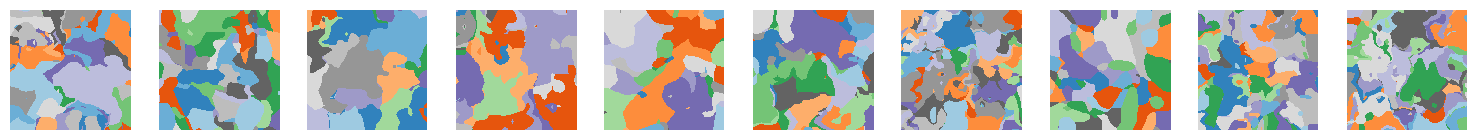

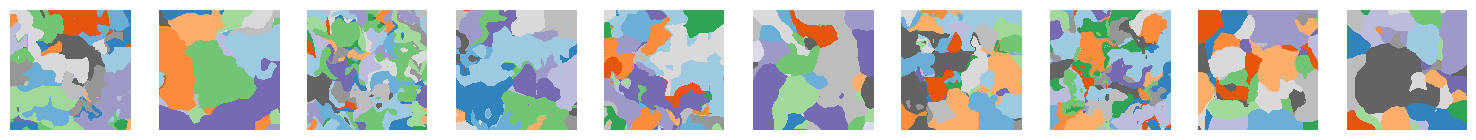

In [3]:
# Input shapes.
in_shape = (256,) * 2 # Label maps dimensions.
num_dim = len(in_shape)
num_label = 16
num_maps = 200 # The number of data pairs we want to train the model with.

# Shape generation.
label_maps = []
for _ in tqdm.tqdm(range(num_maps)):
    # Draw image and warp.
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    label_maps.append(np.uint8(lab)) 
    # The label_maps list contains all the data pairs generated above.


# Visualise shapes.
num_row = 2
per_row = 10
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(label_maps[i:i + per_row], cmaps=['tab20c'])

## 3. Creation of 400 grey-scale images to train the model

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1/1 [==============================] - 0s 44ms/step


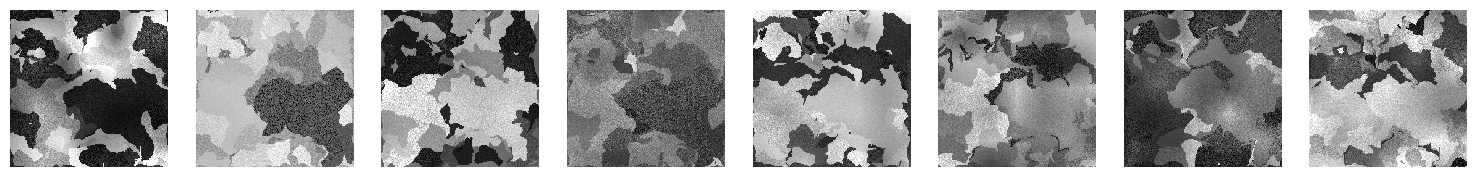

In [4]:
# Image generation. For accurate registration, the landscape of generated warps
# and image contrasts will need to include the target distribution.
gen_arg = dict(
    in_shape=in_shape,
    in_label_list=np.unique(label_maps),
    warp_std=3,
    warp_res=(8, 16, 32),
)
# We separate the grey-scale images created from the label_maps list into two different lists: 
# one containing the grey-scale images corresponding to the "fixed" images and 
# another containing those corresponding to the "moving" images.
gen_model_1 = ne.models.labels_to_image(**gen_arg, id=1)
gen_model_2 = ne.models.labels_to_image(**gen_arg, id=2)


# Test repeatedly for single input.
# We can see several image contrasts from a given image (here from the first "fixed" grey-scale image).
num_gen = 8
input = np.expand_dims(label_maps[0], axis=(0, -1))
slices = [gen_model_1.predict(input)[0] for _ in range(num_gen)]
ne.plot.slices(slices);

## 3. Creation of the model

In [5]:
# Registration model.
reg_model = vxm.networks.VxmDense(
    inshape=in_shape,
    int_resolution=2,
    svf_resolution=2,
    nb_unet_features=([256] * 4, [256] * 8),
    reg_field='warp',
)


# Model for optimisation.
ima_1, map_1 = gen_model_1.outputs
ima_2, map_2 = gen_model_2.outputs

_, warp = reg_model((ima_1, ima_2))
pred = vxm.layers.SpatialTransformer(fill_value=0)((map_1, warp))

inputs = gen_model_1.inputs + gen_model_2.inputs
out = (map_2, pred)
model = tf.keras.Model(inputs, out)
# The inputs in a Keras model are used to define the placeholders or containers for the input data that will 
# be fed into the model during training or inference. 
# They represent the expected shape and type of the input data.


# Compilation.
model.add_loss(vxm.losses.Dice().loss(*out) + tf.repeat(1., tf.shape(pred)[0]))
model.add_loss(vxm.losses.Grad('l2', loss_mult=1).loss(None, warp))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

IOStream.flush timed out
IOStream.flush timed out


## 4. Train SynthMorph over few epochs

Epoch 1/100
100/100 [==============================] - 253s 3s/step - loss: 0.3085
Epoch 2/100
100/100 [==============================] - 253s 3s/step - loss: 0.3244
Epoch 3/100
100/100 [==============================] - 253s 3s/step - loss: 0.3235
Epoch 4/100
100/100 [==============================] - 253s 3s/step - loss: 0.3090
Epoch 5/100
100/100 [==============================] - 253s 3s/step - loss: 0.3162
Epoch 6/100
100/100 [==============================] - 254s 3s/step - loss: 0.3097
Epoch 7/100
100/100 [==============================] - 253s 3s/step - loss: 0.3110
Epoch 8/100
100/100 [==============================] - 252s 3s/step - loss: 0.3125
Epoch 9/100
100/100 [==============================] - 253s 3s/step - loss: 0.3174
Epoch 10/100
100/100 [==============================] - 254s 3s/step - loss: 0.3184
Epoch 11/100
100/100 [==============================] - 253s 3s/step - loss: 0.2996
Epoch 12/100
100/100 [==============================] - 253s 3s/step - loss: 0.3087
E

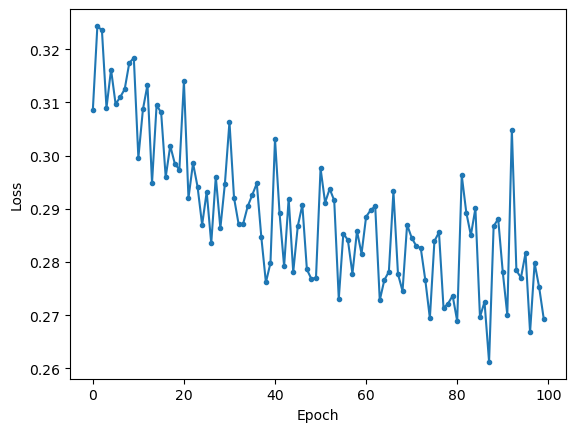

In [7]:
# Train model for a few epochs/periods of time. 
# Re-running the cell will continue training.

gen = vxm.generators.synthmorph(
    label_maps,
    batch_size=1, # Number of samples per gradient update.
    same_subj=True,
    flip=True,
)

hist = model.fit(
    gen,
    initial_epoch=0,
    epochs=100,
    steps_per_epoch=100,
    verbose=1, # Visualise the progress bar.
)


# Visualise loss.
plt.plot(hist.epoch, hist.history['loss'], '.-');
plt.xlabel('Epoch');
plt.ylabel('Loss');